In [1]:
# --- 1. Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# --- 3. Data Directories ---
data_dir = "face_dataset/Original Images"

In [4]:
# --- 4. Image Transformations ---
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize to [-1, 1] output = (input - mean) / std  ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  Rescales [0–1] to [-1, 1] 
])

In [5]:
# Integer tensor (default dtype: int64)
int_tensor = torch.tensor([100, 150, 200])
print("Integer tensor:", int_tensor, "| dtype:", int_tensor.dtype)

# Float tensor (default dtype: float32)
float_tensor = torch.tensor([0.5, 0.8, 0.2])
print("Float tensor:", float_tensor, "| dtype:", float_tensor.dtype)

# Simulate an RGB pixel in [0, 1]
pixel = torch.tensor([0.8, 0.6, 0.4])
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

# Manual normalization
normalized_pixel = (pixel - mean) / std
print("Normalized pixel:", normalized_pixel)

# Using torchvision Normalize (for comparison)
from torchvision import transforms
normalize = transforms.Normalize([0.5]*3, [0.5]*3)

# Reshape pixel to (C, H, W) for Normalize
pixel_reshaped = pixel.view(3, 1, 1) # 1D tensor type 
normalized_pixel_torchvision = normalize(pixel_reshaped)
print("Normalized pixel (torchvision):", normalized_pixel_torchvision.view(3))

Integer tensor: tensor([100, 150, 200]) | dtype: torch.int64
Float tensor: tensor([0.5000, 0.8000, 0.2000]) | dtype: torch.float32
Normalized pixel: tensor([ 0.6000,  0.2000, -0.2000])
Normalized pixel (torchvision): tensor([ 0.6000,  0.2000, -0.2000])


In [6]:
# Load all images (class = folder name)
full_dataset = datasets.ImageFolder("face_dataset/Original Images", transform=transform)

# Split into train / val / test (70/15/15)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size   = int(val_ratio * total_size)
test_size  = total_size - train_size - val_size

train_data, val_data, test_data = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Dataset sizes -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
print("Classes:", full_dataset.classes)

Dataset sizes -> Train: 1793, Val: 384, Test: 385
Classes: ['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


In [7]:
full_dataset.classes


['Akshay Kumar',
 'Alexandra Daddario',
 'Alia Bhatt',
 'Amitabh Bachchan',
 'Andy Samberg',
 'Anushka Sharma',
 'Billie Eilish',
 'Brad Pitt',
 'Camila Cabello',
 'Charlize Theron',
 'Claire Holt',
 'Courtney Cox',
 'Dwayne Johnson',
 'Elizabeth Olsen',
 'Ellen Degeneres',
 'Henry Cavill',
 'Hrithik Roshan',
 'Hugh Jackman',
 'Jessica Alba',
 'Kashyap',
 'Lisa Kudrow',
 'Margot Robbie',
 'Marmik',
 'Natalie Portman',
 'Priyanka Chopra',
 'Robert Downey Jr',
 'Roger Federer',
 'Tom Cruise',
 'Vijay Deverakonda',
 'Virat Kohli',
 'Zac Efron']

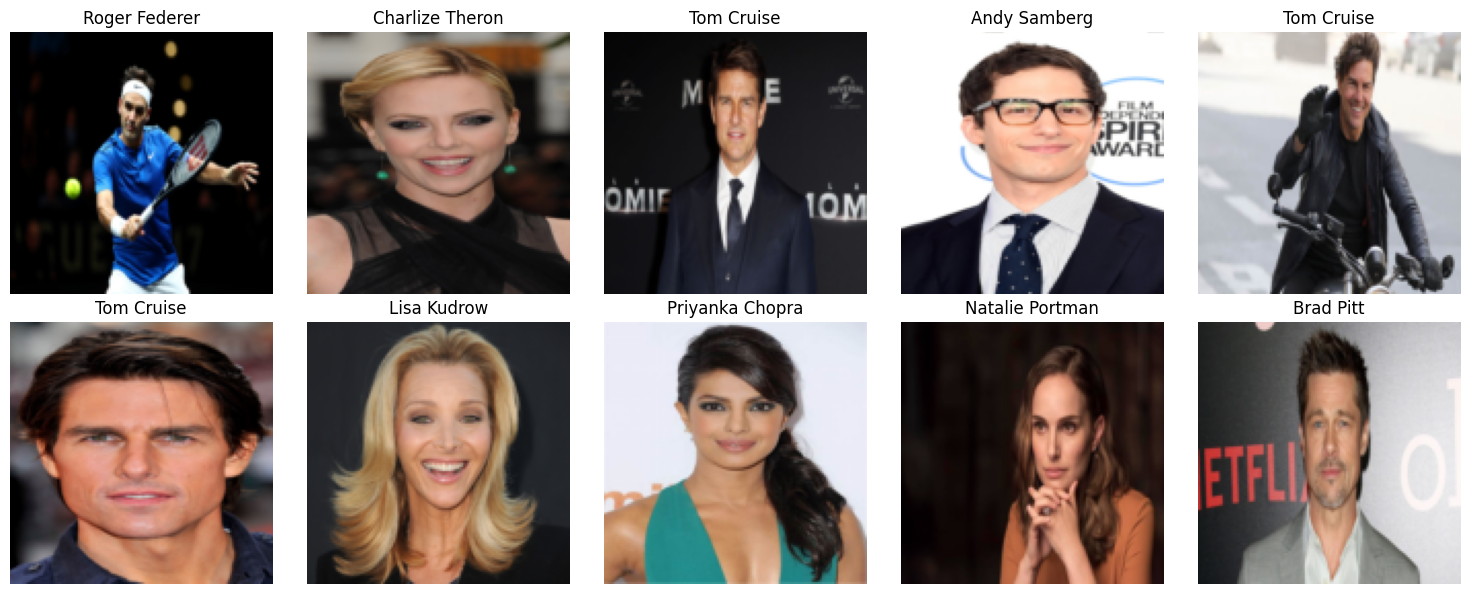

In [8]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # unnormalize if normalized from [-1, 1]
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 6))
for i in range(10):
    idx = random.randint(0, len(train_data) - 1)
    img, label = train_data[idx]
    plt.subplot(2, 5, i+1)
    imshow(img, title=full_dataset.classes[label])
plt.tight_layout()
plt.show()

In [9]:


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16*16*128, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 64x64x32 
        x = self.pool(torch.relu(self.conv2(x))) # 32x32x64
        x = self.pool(torch.relu(self.conv3(x))) # 16x16x128
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=31, bias=True)
)


In [10]:
# --- 8. Loss and Optimizer ---
criterion = nn.CrossEntropyLoss() #Negative log 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# --- 9. Training and Validation Functions ---
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1) 
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [12]:
# --- 10. Training Loop ---
num_epochs = 10
train_losses, val_accuracies = [], []
train_accuracies, val_losses = [], []

def compute_loss(model, loader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(loader)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = compute_loss(model, val_loader, criterion)
    train_acc = evaluate(model, train_loader)
    val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    checkpoint_path = f"plant_cnn_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

Epoch 1/10, Train Loss: 3.3998, Train Acc: 0.0859, Val Loss: 3.3619, Val Acc: 0.0521
Model saved to plant_cnn_epoch1.pth
Epoch 2/10, Train Loss: 3.2718, Train Acc: 0.1506, Val Loss: 3.1691, Val Acc: 0.1172
Model saved to plant_cnn_epoch2.pth
Epoch 3/10, Train Loss: 3.0479, Train Acc: 0.2108, Val Loss: 2.9946, Val Acc: 0.1484
Model saved to plant_cnn_epoch3.pth
Epoch 4/10, Train Loss: 2.9094, Train Acc: 0.2727, Val Loss: 2.9508, Val Acc: 0.1458
Model saved to plant_cnn_epoch4.pth
Epoch 5/10, Train Loss: 2.7200, Train Acc: 0.3408, Val Loss: 2.8778, Val Acc: 0.1536
Model saved to plant_cnn_epoch5.pth
Epoch 6/10, Train Loss: 2.4596, Train Acc: 0.4400, Val Loss: 2.7854, Val Acc: 0.1927
Model saved to plant_cnn_epoch6.pth
Epoch 7/10, Train Loss: 2.1909, Train Acc: 0.5270, Val Loss: 3.0021, Val Acc: 0.1250
Model saved to plant_cnn_epoch7.pth
Epoch 8/10, Train Loss: 1.8868, Train Acc: 0.7245, Val Loss: 3.0619, Val Acc: 0.1719
Model saved to plant_cnn_epoch8.pth
Epoch 9/10, Train Loss: 1.5763, 